# **# Import packets and libraries**

In [1]:
# Import packets and libraries
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.ndimage import distance_transform_edt
from skimage.io import imread
from skimage.color import rgb2gray, rgba2rgb

from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation, BatchNormalization, LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2,ResNet50

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K


In [2]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


In [3]:
tf.config.set_visible_devices([], 'GPU') 
# print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# **# Import datasets**

# **# Pre-processing**

In [5]:
np.random.seed(42)
tf.random.set_seed(42)

In [6]:
IMAGE_SIZE = 256 
EPOCHS = 30       
BATCH = 8         
LR = 1e-4         

# PATH = "Dataset_Path"
PATH = "F:/MMOTU_DS2Net-main/data/OTU-2D-Dataset-main"
# F:\MMOTU_DS2Net-main\data\OTU-2D-Dataset-main

In [7]:
images_arr = []
annotations_arr = []
for i in range(0,1469) :
    path = "F:/MMOTU_DS2Net-main/data/OTU-2D-Dataset-main"
    x = path + "/images/" + str(i+1) + ".JPG"
    y = path + "/annotations/" + str(i+1) + ".PNG"
    images_arr.append(x)
    annotations_arr.append(y)

# **# Import function**

In [8]:
def load_data(path, split=0.1):

    images = sorted(images_arr)
    masks = sorted(annotations_arr)

    total_size = len(images)                # 1469 total images
    valid_size = int(split * total_size)    # 146 images for validation
    test_size = int(split * total_size)     # 146 images for test / 1177 images for training

    train_x, valid_x = train_test_split(images, test_size=valid_size, random_state=42) 
    train_y, valid_y = train_test_split(masks, test_size=valid_size, random_state=42)  

    train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=42)  
    train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=42)  

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [9]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    (thresh, x) = cv2.threshold(x, 0, 1, cv2.THRESH_BINARY)
    x = np.expand_dims(x, axis=-1)
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y
    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
    x.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3]) 
    y.set_shape([IMAGE_SIZE, IMAGE_SIZE, 1]) 
    return x, y

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse) # Tiền xử lý map & batch
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    return dataset

In [10]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(PATH)

print("Training data: ", len(train_y))
print("Validation data: ", len(valid_x))
print("Testing data: ", len(test_x))

Training data:  1177
Validation data:  146
Testing data:  146


In [11]:
train_dataset = tf_dataset(train_x, train_y, batch=BATCH)
valid_dataset = tf_dataset(valid_x, valid_y, batch=BATCH)
test_dataset = tf_dataset(test_x, test_y, batch=BATCH)

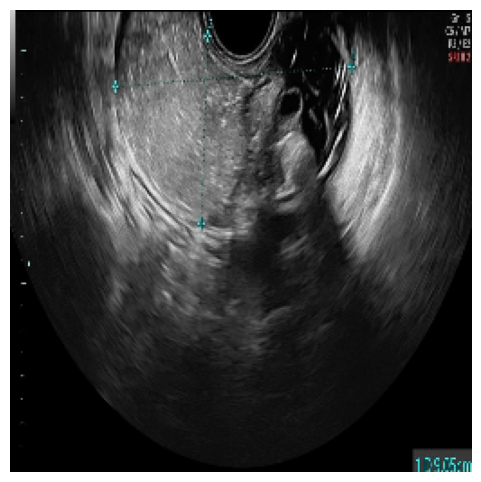

In [12]:
for batch in test_dataset.take(1):
    images, labels = batch  # Assuming tf_dataset returns a tuple of (images, labels)
    break

# Convert TensorFlow tensors to NumPy arrays
images = images.numpy()
labels = labels.numpy()

# Visualize the first image in the batch
plt.figure(figsize=(6, 6))
plt.imshow(images[0], cmap='gray')  # squeeze() removes the channel dimension 
plt.axis('off')
plt.show()

# **# Model**

In [13]:
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from keras.models import Model
from keras.layers import Input, Concatenate, Conv2D, MaxPooling2D

In [14]:
def conv_block(x, num_filters):
    x = L.Conv2D(num_filters, 3, padding="same")(x)
    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)
    x = L.Conv2D(num_filters, 3, padding="same")(x)
    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)
    return x

def encoder_block(x, num_filters):
    x = conv_block(x, num_filters)
    p = L.MaxPool2D((2, 2))(x)
    return x, p

def attention_gate(g, s, num_filters):
    Wg = L.Conv2D(num_filters, 1, padding="same")(g)
    Wg = L.BatchNormalization()(Wg)

    Ws = L.Conv2D(num_filters, 1, padding="same")(s)
    Ws = L.BatchNormalization()(Ws)

    out = L.Activation("relu")(Wg + Ws)
    out = L.Conv2D(num_filters, 1, padding="same")(out)
    out = L.Activation("sigmoid")(out)
    return out * s

def decoder_block(x, s, num_filters):
    x = L.UpSampling2D(interpolation="bilinear")(x)
    s = attention_gate(x, s, num_filters)
    x = L.Concatenate()([x, s])
    x = conv_block(x, num_filters)
    return x

def SPPF_module(x, k = 5):
    B, H, W, C = x.shape # Batch - Height - Width - Channel

    cv1 = Conv2D(C//2, (1,1), strides=(1,1), padding = 'valid')(x)
    cv1 = BatchNormalization()(cv1) 
    # cv1 = tf.nn.silu(cv1) 
    cv1 = L.Activation("silu")(cv1)
    mp1 = MaxPooling2D(pool_size = (k, k), strides = (1, 1), padding = 'same')(cv1) 
    mp2 = MaxPooling2D(pool_size = (k, k), strides = (1, 1), padding = 'same')(mp1)
    mp3 = MaxPooling2D(pool_size = (k, k), strides = (1, 1), padding = 'same')(mp2)

    out = Concatenate(axis=-1)([cv1, mp1, mp2, mp3])
    out = Conv2D(C, (1,1), strides=(1,1), padding = 'valid')(out)
    out = BatchNormalization()(out)
    # out = tf.nn.silu(out)
    out = L.Activation("silu")(out)
    return out

def build_vgg16_attention_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained VGG19 Model """
    vgg16 = VGG16(include_top = False, weights = "imagenet", input_tensor = inputs)

    """ Encoder """
    s1 = vgg16.get_layer("block1_conv2").output;
    s2 = vgg16.get_layer("block2_conv2").output;
    s3 = vgg16.get_layer("block3_conv3").output;
    s4 = vgg16.get_layer("block4_conv3").output;
    b1 = vgg16.get_layer("block5_conv3").output;
    b2 = SPPF_module(b1, k = 5);

    """ Bridge """
    # b1 = vgg19.get_layer("block5_conv4").output

    """ Decoder """
    d1 = decoder_block(b2, s4, 512);
    d2 = decoder_block(d1, s3, 256);
    d3 = decoder_block(d2, s2, 128);
    d4 = decoder_block(d3, s1, 64) ;

    """ Output """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4);
    model = Model(inputs, outputs)
    return model

In [15]:
input = (256, 256, 3)
model = build_vgg16_attention_unet(input) # OUTPUT (256, 256, 1)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 256, 256,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 128, 128,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 128, 128,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 128, 128,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 64, 64,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 64, 64,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 64, 64,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 64, 64,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 32, 32,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 32, 32,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 32, 32,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 32, 32,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 16, 16,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 16, 16,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 16, 16,    │  2,359,808 │ block5_conv1[0][

 Total params: 26,699,073 (101.85 MB)

 Trainable params: 26,689,857 (101.81 MB)

 Non-trainable params: 9,216 (36.00 KB)

In [16]:
import tensorflow as tf
# import keras.backend as K
# from keras.losses import binary_crossentropy, BinaryCrossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy, BinaryCrossentropy

beta = 0.25
alpha = 0.25
gamma = 2
epsilon = 1e-5
smooth = 1e-15

def dice_coef( y_true, y_pred):
    y_true = K.cast(y_true, 'float32')  
    y_pred = K.cast(y_pred, 'float32')
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (
            K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity( y_true, y_pred):
    true_negatives = K.sum(
        K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def convert_to_logits(y_pred):
    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(),
                              1 - tf.keras.backend.epsilon())
    return tf.math.log(y_pred / (1 - y_pred))

def weighted_cross_entropyloss(y_true, y_pred):
    y_pred = convert_to_logits(y_pred)
    pos_weight = beta / (1 - beta)
    loss = tf.nn.weighted_cross_entropy_with_logits(logits=y_pred,
                                                    labels=y_true,
                                                    pos_weight=pos_weight)
    return tf.reduce_mean(loss)

def generalized_dice_coefficient( y_true, y_pred):
    y_true = K.cast(y_true, 'float32')  
    y_pred = K.cast(y_pred, 'float32')
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (
            K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss( y_true, y_pred):
    loss = 1 - generalized_dice_coefficient(y_true, y_pred)
    return loss

def confusion( y_true, y_pred):
    y_pred_pos = K.clip(y_pred, 0, 1)
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.clip(y_true, 0, 1)
    y_neg = 1 - y_pos
    tp = K.sum(y_pos * y_pred_pos)
    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)
    prec = (tp + smooth) / (tp + fp + smooth)
    recall = (tp + smooth) / (tp + fn + smooth)
    return prec, recall

def true_positive(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pos = K.round(K.clip(y_true, 0, 1))
    tp = (K.sum(y_pos * y_pred_pos) + smooth) / (K.sum(y_pos) + smooth)
    return tp

def true_negative( y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos
    tn = (K.sum(y_neg * y_pred_neg) + smooth) / (K.sum(y_neg) + smooth)
    return tn

def jacard_similarity( y_true, y_pred):
    y_true = K.cast(y_true, 'float32')  
    y_pred = K.cast(y_pred, 'float32')
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum((y_true_f + y_pred_f) - (y_true_f * y_pred_f))
    return intersection / union

def jacard_loss(y_true, y_pred):
    return 1 - jacard_similarity(y_true, y_pred)

def ssim_loss(y_true, y_pred):
    return 1 - tf.image.ssim(y_true, y_pred, max_val=1)

def binary_dice(y_true, y_pred):
    return 0.5 *binary_crossentropy(y_true, y_pred) + dice_loss( y_true, y_pred)

def FocalLoss(y_true, y_pred):
    alpha = 0.26
    gamma = 2.3
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')

    inputs = K.flatten(y_pred)
    targets = K.flatten(y_true)

    BCE = K.binary_crossentropy(targets, inputs)
    BCE_EXP = K.exp(-BCE)
    focal_loss = K.mean(alpha * K.pow((1-BCE_EXP), gamma) * BCE)

    return focal_loss
def joint_loss1(y_true, y_pred):
    focal_loss1 = FocalLoss(y_true, y_pred)
    ms_ssim_loss1 = ssim_loss(y_true, y_pred)
    jacard_loss1 = jacard_loss(y_true, y_pred)
    loss =  (focal_loss1 + ms_ssim_loss1 + jacard_loss1)/3
    return loss

In [ ]:
# import tensorflow as tf
# import numpy as np
# from scipy.ndimage import distance_transform_edt

# # def cross_entropy_loss(y_true, y_pred):
# #     """
# #     y_true (tf.Tensor): The ground truth binary masks (N, H, W) where 1 represents the target region (cancer).
# #     y_pred (tf.Tensor): The predicted logits (N, H, W), not probabilities.
# #     """
# #     # Apply sigmoid to logits to get predicted probabilities
# #     predictions = tf.sigmoid(y_pred)
    
# #     # Compute the cross-entropy part (for binary classification)
# #     cross_entropy = -y_true*tf.math.log(predictions + 1e-8)
    
# #     return tf.reduce_mean(cross_entropy)

# def Binary_cross_entropy(y_true, y_pred):
#     return tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)

# def distance_map_cross_entropy_loss(y_true, y_pred):
#     """
#     y_true (tf.Tensor): The ground truth binary masks (N, H, W) where 1 represents the target region (cancer).
#     y_pred (tf.Tensor): The predicted logits (N, H, W), not probabilities.
#     """
#     # reduction = 'none' to get the loss for each pixel
#     cross_entropy = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)  # (N, H, W)
    
#     def compute_distance_map(mask_image):
#         # Convert y_true to binary mask
#         binary_mask = mask_image > 0.5
#         # compute distance transform using scipy (numpy-based)
#         def compute_distance_transform(mask):
#             mask_np = tf.cast(mask, tf.bool)  # Convert mask to boolean numpy array
#             distance_inside = distance_transform_edt(mask_np)
#             distance_outside = distance_transform_edt(~mask_np) 
            
#             distance_inside_normalized = (distance_inside - distance_inside.min()) / (distance_inside.max() - distance_inside.min())
#             distance_outside_normalized = (distance_outside - distance_outside.min()) / (distance_outside.max() - distance_outside.min())

#             combined_distance_map = distance_inside_normalized + distance_outside_normalized
#             inverted_map = np.max(combined_distance_map) - combined_distance_map
#             return inverted_map

#         # Wrap inside tf.py_function to allow numpy operations
#         inverted_map = tf.py_function(compute_distance_transform, [binary_mask], tf.float32)
#         # TensorFlow will not track this operation as part of the graph --> convert the result back
#         inverted_map.set_shape(mask_image.shape)  
#         return inverted_map
    
#     # Vectorized computation of distance map across the batch
#     distance_maps = tf.map_fn(lambda x: compute_distance_map(x), y_true, dtype=tf.float32)
    
#     N = tf.shape(y_true)[0]  # Batch size
#     H, W = tf.shape(y_true)[1], tf.shape(y_true)[2]  # Height and width of the image
#     H = tf.cast(H, tf.float32)
#     W = tf.cast(W, tf.float32)
#     # Expand distance map to match shape (N, H, W, 1) for broadcasting
#     distance_map_expanded = tf.expand_dims(distance_maps, axis=-1)  # Shape becomes (N, H, W, 1)
#     # normalized
#     distance_map_expanded = distance_map_expanded / tf.reduce_max(distance_map_expanded, axis=[1, 2], keepdims=True)
    
#     weighted_cross_entropy = (1 + distance_map_expanded)*tf.expand_dims(cross_entropy,axis=-1)
    
#     loss = tf.reduce_sum(weighted_cross_entropy, axis=[1, 2, 3])  # Sum over H, W, and K
#     loss = loss / (H * W)  
    
#     return loss

# **# Compile Model**

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint

# checkpoint_path = "Save-epoch-path.{epoch:02d}.h5"
checkpoint_path = "Save-epoch-path.{epoch:02d}.weights.h5"

checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    verbose=1,
    save_best_only=False,
    save_weights_only=True,
    mode='auto',
    save_freq='epoch'
)

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False),
    checkpoint_callback
]

In [18]:
model.load_weights("Save-epoch-path.17.weights.h5")

In [19]:
train_steps = len(train_x) // BATCH
valid_steps = len(valid_x) // BATCH

if len(train_x) % BATCH != 0:
    train_steps += 1
if len(valid_x) % BATCH != 0:
    valid_steps += 1

print(train_steps)
print(valid_steps)

148
19


In [39]:
opt = tf.keras.optimizers.Nadam(LR)
metrics = [dice_coef, jacard_similarity, tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]

model.compile(loss=joint_loss1, optimizer=opt, metrics=metrics)

In [126]:
opt = tf.keras.optimizers.Nadam(LR)
metrics = [dice_coef, jacard_similarity, tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]

model.compile(loss=distance_map_cross_entropy_loss, optimizer=opt, metrics=metrics)

history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=1,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks
)

  6/148 ━━━━━━━━━━━━━━━━━━━━ 21:20 9s/step - dice_coef: 0.2290 - jacard_similarity: 0.1296 - loss: 0.9180 - precision_11: 0.2130 - recall_11: 0.3660

KeyboardInterrupt: 

In [20]:
model_path = 'Save-epoch-path.17.weights.h5'
model.load_weights(model_path)

In [41]:
test_dataset = tf_dataset(test_x, test_y, batch=BATCH)

test_steps = (len(test_x)//BATCH)
if len(test_x) % BATCH != 0:
    test_steps += 1
model.evaluate(test_dataset, steps=test_steps)

19/19 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - dice_coef: 0.8649 - jacard_similarity: 0.7657 - loss: 0.1259 - precision_1: 0.8743 - recall_1: 0.8709


[0.11491997539997101,
 0.8776941895484924,
 0.7855249643325806,
 0.882042646408081,
 0.8943828344345093]

In [25]:
image_path = 'F:/MMOTU_DS2Net-main/data/OTU-2D-Dataset-main/images/29.jpg'
# Read the image in color (OpenCV loads in BGR)
img_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
if img_bgr is None:
    raise ValueError("Image not found or unable to load. Check the provided path.")

# Convert BGR to RGB
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# Resize image to (256, 256) to match the model input
img_resized = cv2.resize(img_rgb, (256, 256))

# Normalize pixel values to [0, 1]
img_normalized = img_resized.astype(np.float32) / 255.0

# Expand dimensions to form a batch (1, 256, 256, 3)
img_input = np.expand_dims(img_normalized, axis=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step


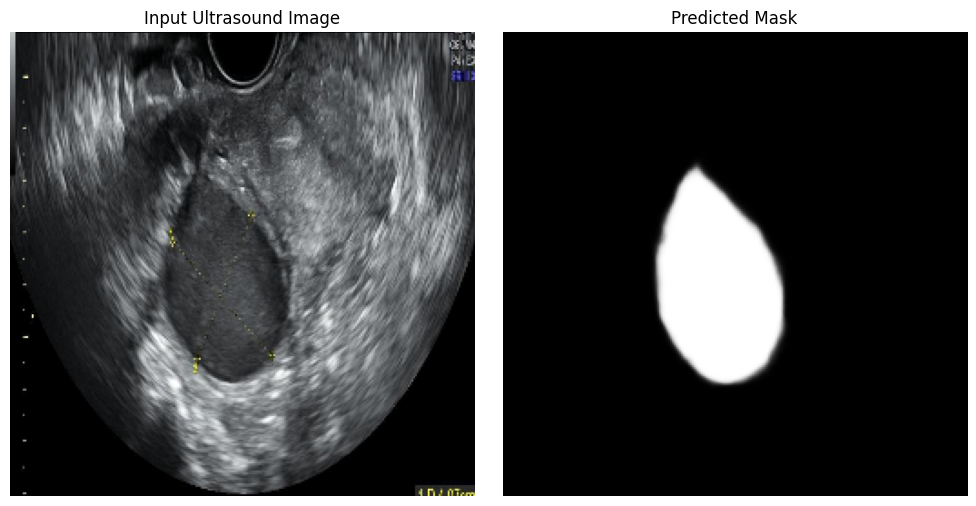

In [27]:
# --- Predict the Segmentation Mask ---
pred_mask_batch = model.predict(img_input)  # Expected output shape: (1, 256, 256, 1)
pred_mask = pred_mask_batch[0]  # Remove the batch dimension -> (256, 256, 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_resized)
plt.title("Input Ultrasound Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(pred_mask[:, :, 0], cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")

plt.tight_layout()
plt.show()